In [1]:
!pip install q keras==3.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [6]:
import os
import requests
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow
from keras.preprocessing import image
from tensorflow.keras import applications
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import F1Score

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Concatenate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/Fac/DL2/new_dataset_arrays.zip" -d "/content"

Archive:  /content/drive/My Drive/Fac/DL2/new_dataset_arrays.zip
  inflating: /content/new_dataset_arrays.pkl  


### Build the models

In [5]:
pickle_file_path = '/content/new_dataset_arrays.pkl'
dataset1 = pd.read_pickle(pickle_file_path)

In [ ]:
def create_label_mapping(label, unique_values):
    label_map = {}
    for i, value in enumerate(unique_values):
        label_map[value] = i
    return label_map.get(label, -1)

unique_nine_partition_labels = ['inflammatory', 'benign dermal', 'malignant dermal', 'malignant melanoma',
                                 'genodermatoses', 'malignant epidermal', 'benign epidermal',
                                 'benign melanocyte', 'malignant cutaneous lymphoma']

unique_three_partition_labels = ['non-neoplastic', 'benign', 'malignant']

dataset1['nine_partition_encoded'] = dataset1['nine_partition_label'].apply(lambda x: create_label_mapping(x, unique_nine_partition_labels))
dataset1['three_partition_encoded'] = dataset1['three_partition_label'].apply(lambda x: create_label_mapping(x, unique_three_partition_labels))


In [ ]:
dataset1=dataset1.rename(columns = {'image_array_sq':'image_array'})

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(dataset1[['image_array', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'nine_partition_encoded', 'three_partition_encoded']],
                                                    dataset1['label'], test_size=0.25, random_state=42, stratify=dataset1['label'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

arrange the two inputs of the models

In [ ]:
X_train_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_train['image_array'].values))
X_val_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_val['image_array'].values))
X_test_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_test['image_array'].values))

In [ ]:
X_train_features = X_train[['fitzpatrick_scale', 'nine_partition_encoded', 'three_partition_encoded']]
X_val_features = X_val[['fitzpatrick_scale',  'nine_partition_encoded', 'three_partition_encoded']]
X_test_features = X_test[['fitzpatrick_scale', 'nine_partition_encoded', 'three_partition_encoded']]

encode the labels we want to predict on

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded_onehot = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_encoded_onehot = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_encoded_onehot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

# Multi input Stacking XGBoost

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.0001],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
}

xgb_classifier = XGBClassifier(
    objective='multi:softmax',
    num_class=114,
    eval_metric='mlogloss'
)


grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train_features, y_train_encoded)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5}
Best F1 Score: 0.15970594474633246


In [ ]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=114,
    eval_metric='mlogloss',
    gama = 0,
    learning_rate = 0.1,
    max_depth = 5
)

xgb_model.fit(X_train_features, y_train_encoded)

y_pred_xg = xgb_model.predict(X_test_features)

accuracy = accuracy_score(y_test_encoded, y_pred_xg)
f1 = f1_score(y_test_encoded, y_pred_xg, average='macro')
print("Accuracy:", accuracy)
print("F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gama" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.1732283464566929
F1 Score: 0.0796768288333738


In [ ]:
from tensorflow.keras import applications
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

for layer in base_model.layers[:-2]:
    layer.trainable = False

from tensorflow.keras import models, layers
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)
prediction_layer = layers.Dense(114, activation='softmax')

model2 = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_1,
    dense_layer_2,
    dropout_2,
    prediction_layer
])

base_learning_rate = 0.00001

model2.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history = model2.fit(
    X_train_img,
    y_train_encoded_onehot,
    epochs = 30,
    validation_data = (X_val_img, y_val_encoded_onehot),
    batch_size = 64,
    verbose=1,
    callbacks=[es],
    shuffle = True)

Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 195s 562ms/step - accuracy: 0.0151 - f1_score_macro: 0.0096 - f1_score_micro: 0.0151 - f1_score_weighted: 0.0141 - loss: 5.1832 - val_accuracy: 0.0848 - val_f1_score_macro: 0.0220 - val_f1_score_micro: 0.0848 - val_f1_score_weighted: 0.0489 - val_loss: 4.5096
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.0447 - f1_score_macro: 0.0209 - f1_score_micro: 0.0447 - f1_score_weighted: 0.0386 - loss: 4.5768 - val_accuracy: 0.1208 - val_f1_score_macro: 0.0470 - val_f1_score_micro: 0.1208 - val_f1_score_weighted: 0.0747 - val_loss: 4.3264
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.0794 - f1_score_macro: 0.0386 - f1_score_micro: 0.0794 - f1_score_weighted: 0.0671 - loss: 4.3752 - val_accuracy: 0.1450 - val_f1_score_macro: 0.0666 - val_f1_score_micro: 0.1450 - val_f1_score_weighted: 0.0964 - val_loss: 4.1613
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.1006 - f1_score_macro: 0.0541 - f

In [ ]:
y_pred_cnn = model2.predict(X_test_img)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step


In [ ]:
y_pred_xg_train = xgb_model.predict(X_train_features)
y_pred_xg_val = xgb_model.predict(X_val_features)
y_pred_xg_test = xgb_model.predict(X_test_features)

In [ ]:
y_pred_cnn_train = model2.predict(X_train_img)
y_pred_classes_cnn_train = np.argmax(y_pred_cnn_train, axis=1)
y_pred_cnn_val = model2.predict(X_val_img)
y_pred_classes_cnn_val = np.argmax(y_pred_cnn_val, axis=1)
y_pred_cnn_test = model2.predict(X_test_img)
y_pred_classes_cnn_test = np.argmax(y_pred_cnn_test, axis=1)

387/387 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


In [ ]:
y_pred_xg_train.shape

(12379,)

In [ ]:
xg_input = Input(shape=(1,), name='xg_input')
cnn_input = Input(shape=(1,), name='cnn_input')

concatenated = Concatenate()([xg_input, cnn_input])

dropout_7 = layers.Dropout(0.5)

x = Dense(256, activation='relu')(concatenated)
x = dropout_7(x)
x = Dense(128, activation='relu')(x)
output = Dense(114, activation='softmax')(x)

meta_model = Model(inputs=[xg_input, cnn_input], outputs=output)

In [ ]:
y_pred_xg_val.shape

(2476,)

In [ ]:
y_pred_xg_train.shape

(12379,)

In [ ]:
base_learning_rate = 0.0001
meta_model.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history2 = meta_model.fit({'xg_input': y_pred_xg_train, 'cnn_input': y_pred_classes_cnn_train},
    y_train_encoded_onehot,
    epochs = 20,
    validation_data=({'xg_input': y_pred_xg_val, 'cnn_input': y_pred_classes_cnn_val}, y_val_encoded_onehot),
    batch_size = 64,
    verbose=1,
    callbacks=[es],
    shuffle = True)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.0107 - f1_score_macro: 0.0067 - f1_score_micro: 0.0107 - f1_score_weighted: 0.0089 - loss: 11.8229 - val_accuracy: 0.0186 - val_f1_score_macro: 0.0024 - val_f1_score_micro: 0.0186 - val_f1_score_weighted: 0.0049 - val_loss: 4.7129
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0246 - f1_score_macro: 0.0127 - f1_score_micro: 0.0246 - f1_score_weighted: 0.0231 - loss: 5.8060 - val_accuracy: 0.0460 - val_f1_score_macro: 0.0022 - val_f1_score_micro: 0.0460 - val_f1_score_weighted: 0.0074 - val_loss: 4.6965
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0313 - f1_score_macro: 0.0124 - f1_score_micro: 0.0313 - f1_score_weighted: 0.0247 - loss: 4.8131 - val_accuracy: 0.0404 - val_f1_score_macro: 0.0020 - val_f1_score_micro: 0.0404 - val_f1_score_weighted: 0.0067 - val_loss: 4.6829
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0418 - f1_score_macro: 0.0138 - f1_score_mic

In [ ]:
evaluation_result = meta_model.evaluate({'xg_input': y_pred_xg_test, 'cnn_input': y_pred_classes_cnn_test}, y_test_encoded_onehot)
print("Evaluation result:", evaluation_result)

y_pred_meta_model = meta_model.predict({'xg_input': y_pred_xg_test, 'cnn_input': y_pred_classes_cnn_test})
y_pred_classes_meta_model = np.argmax(y_pred_meta_model, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0653 - f1_score_macro: 0.0073 - f1_score_micro: 0.0653 - f1_score_weighted: 0.0250 - loss: 4.6697
Evaluation result: [4.695980072021484, 0.05330102890729904, 0.01603405550122261, 0.05330098047852516, 0.005847333464771509]
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


get the classification report

In [ ]:
y_test_original_meta_model = label_encoder.inverse_transform(np.argmax(y_test_encoded_onehot, axis=1))
y_pred_classes_original_meta_model = label_encoder.inverse_transform(y_pred_classes_meta_model)

report = classification_report(y_test_original_meta_model, y_pred_classes_original_meta_model)

print(report)

                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.00      0.00      0.00         9
                                                 acne       0.00      0.00      0.00        19
                                        acne vulgaris       0.23      0.65      0.34        34
acquired autoimmune bullous diseaseherpes gestationis       0.00      0.00      0.00         6
                         acrodermatitis enteropathica       0.00      0.00      0.00         9
                                    actinic keratosis       0.00      0.00      0.00        18
                          allergic contact dermatitis       0.05      0.37      0.10        43
                                        aplasia cutis       0.00      0.00      0.00         7
                                 basal cell carcinoma       0.00      0.00      0.00        47
                     basal cell carcinoma morphei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1 = f1_score(y_test_original_meta_model, y_pred_classes_original_meta_model, average='weighted')
print("Weighted F1 Score : ", f1)

Weighted F1 Score :  0.01603405827420136


In [ ]:
f1 = f1_score(y_test_original_meta_model, y_pred_classes_original_meta_model, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.05330102967898243


In [ ]:
f1 = f1_score(y_test_original_meta_model, y_pred_classes_original_meta_model, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.005847334066869712


In [ ]:
final_val_loss = history2.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 4.683321475982666


# Multi Input - RMSprop

In [ ]:
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_input = Input(shape=(300, 300, 3), name='image_input')
features_input = Input(shape=(3,), name='features_input')

dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)

image_features = base_model(image_input)
image_flattened = Flatten()(image_features)
dense_output_1 = dense_layer_1(image_flattened)
dropout_output_1 = dropout_1(dense_output_1)
dense_output_2 = dense_layer_2(dropout_output_1)
dropout_output_2 = dropout_2(dense_output_2)

dropout_4 = layers.Dropout(0.5)
dropout_5 = layers.Dropout(0.5)
dropout_6 = layers.Dropout(0.5)

features_mlp = Dense(512, activation='relu')(features_input)
features_mlp = Dense(256, activation='relu')(features_mlp)
features_mlp = Dense(128, activation='relu')(features_mlp)

concatenated = Concatenate()([dropout_output_2, features_mlp])

x = Dense(256, activation='relu')(concatenated)
output = Dense(114, activation='softmax')(x)

model = Model(inputs=[image_input, features_input], outputs=output)

run the model

In [ ]:
base_learning_rate = 0.00001

model.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history = model.fit({'image_input': X_train_img, 'features_input': X_train_features},
                    y_train_encoded_onehot,
                    epochs=20,
                    batch_size=32,
                    validation_data=({'image_input': X_val_img, 'features_input': X_val_features}, y_val_encoded_onehot),
                    callbacks=[es],
                    shuffle = True)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 327s 543ms/step - accuracy: 0.0111 - f1_score_macro: 0.0051 - f1_score_micro: 0.0111 - f1_score_weighted: 0.0075 - loss: 5.0155 - val_accuracy: 0.0481 - val_f1_score_macro: 0.0129 - val_f1_score_micro: 0.0481 - val_f1_score_weighted: 0.0265 - val_loss: 4.5910
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 114s 294ms/step - accuracy: 0.0375 - f1_score_macro: 0.0135 - f1_score_micro: 0.0375 - f1_score_weighted: 0.0252 - loss: 4.6090 - val_accuracy: 0.0929 - val_f1_score_macro: 0.0209 - val_f1_score_micro: 0.0929 - val_f1_score_weighted: 0.0455 - val_loss: 4.4262
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 114s 294ms/step - accuracy: 0.0648 - f1_score_macro: 0.0182 - f1_score_micro: 0.0648 - f1_score_weighted: 0.0404 - loss: 4.4247 - val_accuracy: 0.1167 - val_f1_score_macro: 0.0300 - val_f1_score_micro: 0.1167 - val_f1_score_weighted: 0.0607 - val_loss: 4.2721
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 114s 294ms/step - accuracy: 0.0986 - f1_score_macro: 0.0285 

predict on the model with test data

In [ ]:
evaluation_result = model.evaluate({'image_input': X_test_img, 'features_input': X_test_features}, y_test_encoded_onehot)
print("Evaluation result:", evaluation_result)

y_pred = model.predict({'image_input': X_test_img, 'features_input': X_test_features})
y_pred_classes = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.4010 - f1_score_macro: 0.2902 - f1_score_micro: 0.4010 - f1_score_weighted: 0.3761 - loss: 2.5098
Evaluation result: [2.4837400913238525, 0.41611143946647644, 0.3933764696121216, 0.41611140966415405, 0.34060758352279663]
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step


get the classification report

In [ ]:
y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded_onehot, axis=1))
y_pred_classes_original = label_encoder.inverse_transform(y_pred_classes)

report = classification_report(y_test_original, y_pred_classes_original)

print(report)

                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.12      0.11      0.12         9
                                                 acne       0.38      0.32      0.34        19
                                        acne vulgaris       0.35      0.76      0.48        34
acquired autoimmune bullous diseaseherpes gestationis       0.00      0.00      0.00         6
                         acrodermatitis enteropathica       0.67      0.44      0.53         9
                                    actinic keratosis       0.47      0.44      0.46        18
                          allergic contact dermatitis       0.19      0.33      0.24        43
                                        aplasia cutis       0.22      0.29      0.25         7
                                 basal cell carcinoma       0.48      0.57      0.52        47
                     basal cell carcinoma morphei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


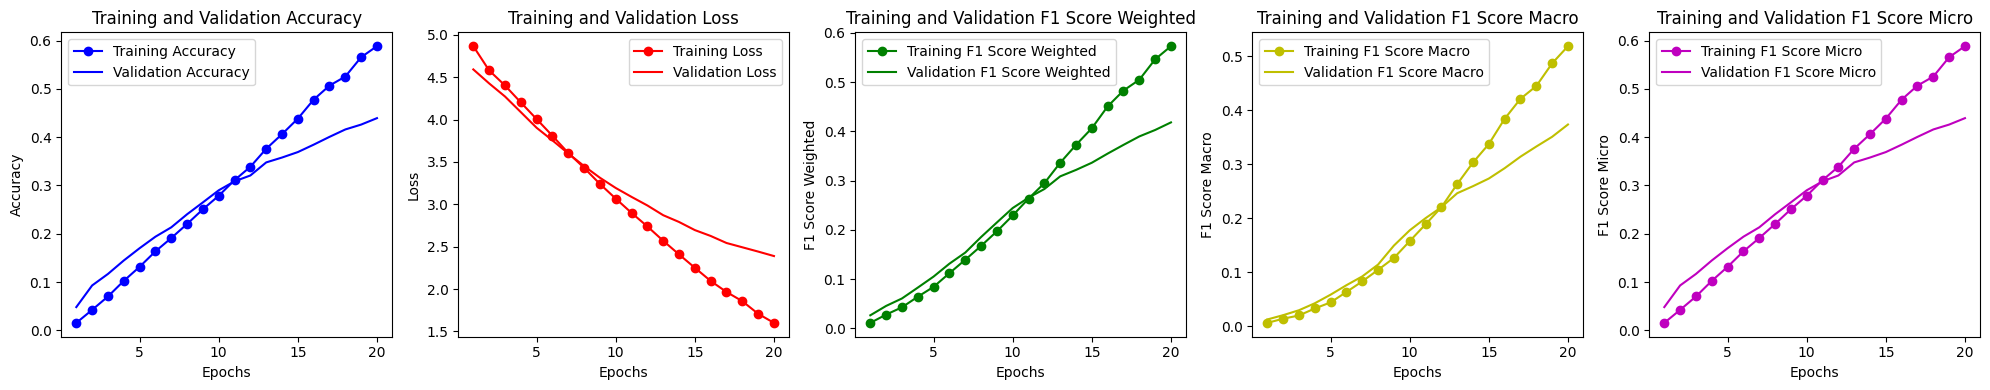

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score_weighted = history.history['f1_score_weighted']
val_f1_score_weighted = history.history['val_f1_score_weighted']
f1_score_macro = history.history['f1_score_macro']
val_f1_score_macro = history.history['val_f1_score_macro']
f1_score_micro = history.history['f1_score_micro']
val_f1_score_micro = history.history['val_f1_score_micro']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 5, 2)
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 5, 3)
plt.plot(epochs, f1_score_weighted, 'go-', label='Training F1 Score Weighted')
plt.plot(epochs, val_f1_score_weighted, 'g-', label='Validation F1 Score Weighted')
plt.title('Training and Validation F1 Score Weighted')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Weighted')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(epochs, f1_score_macro, 'yo-', label='Training F1 Score Macro')
plt.plot(epochs, val_f1_score_macro, 'y-', label='Validation F1 Score Macro')
plt.title('Training and Validation F1 Score Macro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Macro')
plt.legend()

plt.subplot(1, 5, 5)
plt.plot(epochs, f1_score_micro, 'mo-', label='Training F1 Score Micro')
plt.plot(epochs, val_f1_score_micro, 'm-', label='Validation F1 Score Micro')
plt.title('Training and Validation F1 Score Micro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Micro')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='weighted')
print("Weighted F1 Score : ", f1)

Weighted F1 Score :  0.39337650922163653


In [ ]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.4161114476075106


In [ ]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.3406076540356885


In [ ]:
final_val_loss = history.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 2.3896267414093018


# Multi input Class Weights

In [7]:
dataset1 = pd.read_pickle(pickle_file_path)

In [8]:
def create_label_mapping(label, unique_values):
    label_map = {}
    for i, value in enumerate(unique_values):
        label_map[value] = i
    return label_map.get(label, -1)

unique_nine_partition_labels = ['inflammatory', 'benign dermal', 'malignant dermal', 'malignant melanoma',
                                 'genodermatoses', 'malignant epidermal', 'benign epidermal',
                                 'benign melanocyte', 'malignant cutaneous lymphoma']

unique_three_partition_labels = ['non-neoplastic', 'benign', 'malignant']

dataset1['nine_partition_encoded'] = dataset1['nine_partition_label'].apply(lambda x: create_label_mapping(x, unique_nine_partition_labels))
dataset1['three_partition_encoded'] = dataset1['three_partition_label'].apply(lambda x: create_label_mapping(x, unique_three_partition_labels))


In [9]:
dataset1=dataset1.rename(columns = {'image_array_sq':'image_array'})

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(dataset1[['image_array', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'nine_partition_encoded', 'three_partition_encoded']],
                                                    dataset1['label'], test_size=0.25, random_state=42, stratify=dataset1['label'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

In [11]:
# class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

arrange the two inputs of the models

In [12]:
X_train_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_train['image_array'].values))
X_val_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_val['image_array'].values))
X_test_img = tensorflow.keras.applications.efficientnet.preprocess_input(np.stack(X_test['image_array'].values))

In [13]:
X_train_features = X_train[['fitzpatrick_scale', 'nine_partition_encoded', 'three_partition_encoded']]
X_val_features = X_val[['fitzpatrick_scale',  'nine_partition_encoded', 'three_partition_encoded']]
X_test_features = X_test[['fitzpatrick_scale', 'nine_partition_encoded', 'three_partition_encoded']]

encode the labels we want to predict on

In [14]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded_onehot = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_encoded_onehot = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_encoded_onehot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

In [15]:
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_input = Input(shape=(300, 300, 3), name='image_input')
features_input = Input(shape=(3,), name='features_input')

dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)

image_features = base_model(image_input)
image_flattened = Flatten()(image_features)
dense_output_1 = dense_layer_1(image_flattened)
dropout_output_1 = dropout_1(dense_output_1)
dense_output_2 = dense_layer_2(dropout_output_1)
dropout_output_2 = dropout_2(dense_output_2)

dropout_4 = layers.Dropout(0.5)
dropout_5 = layers.Dropout(0.5)
dropout_6 = layers.Dropout(0.5)

features_mlp = Dense(512, activation='relu')(features_input)
features_mlp = Dense(256, activation='relu')(features_mlp)
features_mlp = Dense(128, activation='relu')(features_mlp)

concatenated = Concatenate()([dropout_output_2, features_mlp])

x = Dense(256, activation='relu')(concatenated)
output = Dense(114, activation='softmax')(x)

model = Model(inputs=[image_input, features_input], outputs=output)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


run the model

In [16]:
base_learning_rate = 0.00001

model.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history = model.fit({'image_input': X_train_img, 'features_input': X_train_features},
                    y_train_encoded_onehot,
                    epochs=20,
                    class_weight=class_weights_dict,
                    validation_data=({'image_input': X_val_img, 'features_input': X_val_features}, y_val_encoded_onehot),
                    callbacks=[es],
                    shuffle = True)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 408s 641ms/step - accuracy: 0.0118 - f1_score_macro: 0.0073 - f1_score_micro: 0.0118 - f1_score_weighted: 0.0097 - loss: 4.9866 - val_accuracy: 0.0335 - val_f1_score_macro: 0.0217 - val_f1_score_micro: 0.0335 - val_f1_score_weighted: 0.0224 - val_loss: 4.6686
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 112s 288ms/step - accuracy: 0.0192 - f1_score_macro: 0.0129 - f1_score_micro: 0.0192 - f1_score_weighted: 0.0160 - loss: 4.7357 - val_accuracy: 0.0711 - val_f1_score_macro: 0.0404 - val_f1_score_micro: 0.0711 - val_f1_score_weighted: 0.0480 - val_loss: 4.6149
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 112s 290ms/step - accuracy: 0.0316 - f1_score_macro: 0.0227 - f1_score_micro: 0.0316 - f1_score_weighted: 0.0276 - loss: 4.6334 - val_accuracy: 0.0828 - val_f1_score_macro: 0.0461 - val_f1_score_micro: 0.0828 - val_f1_score_weighted: 0.0538 - val_loss: 4.5243
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 112s 290ms/step - accuracy: 0.0571 - f1_score_macro: 0.0401 

predict on the model with test data

In [17]:
evaluation_result = model.evaluate({'image_input': X_test_img, 'features_input': X_test_features}, y_test_encoded_onehot)
print("Evaluation result:", evaluation_result)

y_pred = model.predict({'image_input': X_test_img, 'features_input': X_test_features})
y_pred_classes = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.3344 - f1_score_macro: 0.2925 - f1_score_micro: 0.3344 - f1_score_weighted: 0.3171 - loss: 2.7604
Evaluation result: [2.7486672401428223, 0.3397940695285797, 0.3264184892177582, 0.33979400992393494, 0.3257621228694916]
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step


get the classification report

In [18]:
y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded_onehot, axis=1))
y_pred_classes_original = label_encoder.inverse_transform(y_pred_classes)

report = classification_report(y_test_original, y_pred_classes_original)

print(report)

                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.40      0.44      0.42         9
                                                 acne       0.20      0.05      0.08        19
                                        acne vulgaris       0.54      0.62      0.58        34
acquired autoimmune bullous diseaseherpes gestationis       0.00      0.00      0.00         6
                         acrodermatitis enteropathica       0.60      0.33      0.43         9
                                    actinic keratosis       0.23      0.33      0.27        18
                          allergic contact dermatitis       0.25      0.02      0.04        43
                                        aplasia cutis       0.22      0.57      0.32         7
                                 basal cell carcinoma       0.57      0.34      0.43        47
                     basal cell carcinoma morphei

In [20]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='weighted')
print("Weighted F1 Score : ", f1)

Weighted F1 Score :  0.32641851796322535


In [21]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.33979406420351305


In [22]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.3257621908866778


In [23]:
final_val_loss = history.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 2.720123767852783


# Multi Input - Adam

In [24]:
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_input = Input(shape=(300, 300, 3), name='image_input')
features_input = Input(shape=(3,), name='features_input')

dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)

image_features = base_model(image_input)
image_flattened = Flatten()(image_features)
dense_output_1 = dense_layer_1(image_flattened)
dropout_output_1 = dropout_1(dense_output_1)
dense_output_2 = dense_layer_2(dropout_output_1)
dropout_output_2 = dropout_2(dense_output_2)

dropout_4 = layers.Dropout(0.5)
dropout_5 = layers.Dropout(0.5)
dropout_6 = layers.Dropout(0.5)

features_mlp = Dense(512, activation='relu')(features_input)
features_mlp = Dense(256, activation='relu')(features_mlp)
features_mlp = Dense(128, activation='relu')(features_mlp)

concatenated = Concatenate()([dropout_output_2, features_mlp])

x = Dense(256, activation='relu')(concatenated)
output = Dense(114, activation='softmax')(x)

model = Model(inputs=[image_input, features_input], outputs=output)

run the model

In [25]:
base_learning_rate = 0.00001

model.compile(optimizer=optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history = model.fit({'image_input': X_train_img, 'features_input': X_train_features},
                    y_train_encoded_onehot,
                    epochs=20,
                    validation_data=({'image_input': X_val_img, 'features_input': X_val_features}, y_val_encoded_onehot),
                    callbacks=[es],
                    shuffle = True)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 374s 590ms/step - accuracy: 0.0177 - f1_score_macro: 0.0048 - f1_score_micro: 0.0177 - f1_score_weighted: 0.0104 - loss: 4.9602 - val_accuracy: 0.0610 - val_f1_score_macro: 0.0133 - val_f1_score_micro: 0.0610 - val_f1_score_weighted: 0.0292 - val_loss: 4.5790
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 115s 296ms/step - accuracy: 0.0500 - f1_score_macro: 0.0130 - f1_score_micro: 0.0500 - f1_score_weighted: 0.0281 - loss: 4.5901 - val_accuracy: 0.1014 - val_f1_score_macro: 0.0236 - val_f1_score_micro: 0.1014 - val_f1_score_weighted: 0.0510 - val_loss: 4.4110
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 116s 300ms/step - accuracy: 0.0790 - f1_score_macro: 0.0190 - f1_score_micro: 0.0790 - f1_score_weighted: 0.0405 - loss: 4.3857 - val_accuracy: 0.1256 - val_f1_score_macro: 0.0345 - val_f1_score_micro: 0.1256 - val_f1_score_weighted: 0.0682 - val_loss: 4.2340
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 116s 301ms/step - accuracy: 0.1151 - f1_score_macro: 0.0336 

predict on the model with test data

In [26]:
evaluation_result = model.evaluate({'image_input': X_test_img, 'features_input': X_test_features}, y_test_encoded_onehot)
print("Evaluation result:", evaluation_result)

y_pred = model.predict({'image_input': X_test_img, 'features_input': X_test_features})
y_pred_classes = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.4478 - f1_score_macro: 0.3513 - f1_score_micro: 0.4478 - f1_score_weighted: 0.4279 - loss: 2.2944
Evaluation result: [2.3210349082946777, 0.44579043984413147, 0.4249287545681, 0.4457903802394867, 0.3836340308189392]
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step


get the classification report

In [27]:
y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded_onehot, axis=1))
y_pred_classes_original = label_encoder.inverse_transform(y_pred_classes)

report = classification_report(y_test_original, y_pred_classes_original)

print(report)

                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.75      0.33      0.46         9
                                                 acne       0.36      0.26      0.30        19
                                        acne vulgaris       0.41      0.76      0.54        34
acquired autoimmune bullous diseaseherpes gestationis       0.00      0.00      0.00         6
                         acrodermatitis enteropathica       0.71      0.56      0.63         9
                                    actinic keratosis       0.38      0.33      0.35        18
                          allergic contact dermatitis       0.34      0.28      0.31        43
                                        aplasia cutis       0.60      0.43      0.50         7
                                 basal cell carcinoma       0.44      0.62      0.51        47
                     basal cell carcinoma morphei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='weighted')
print("Weighted F1 Score : ", f1)

Weighted F1 Score :  0.4249288171424054


In [29]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.44579043004239854


In [30]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.38363407982201125


In [31]:
final_val_loss = history.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 2.2415597438812256


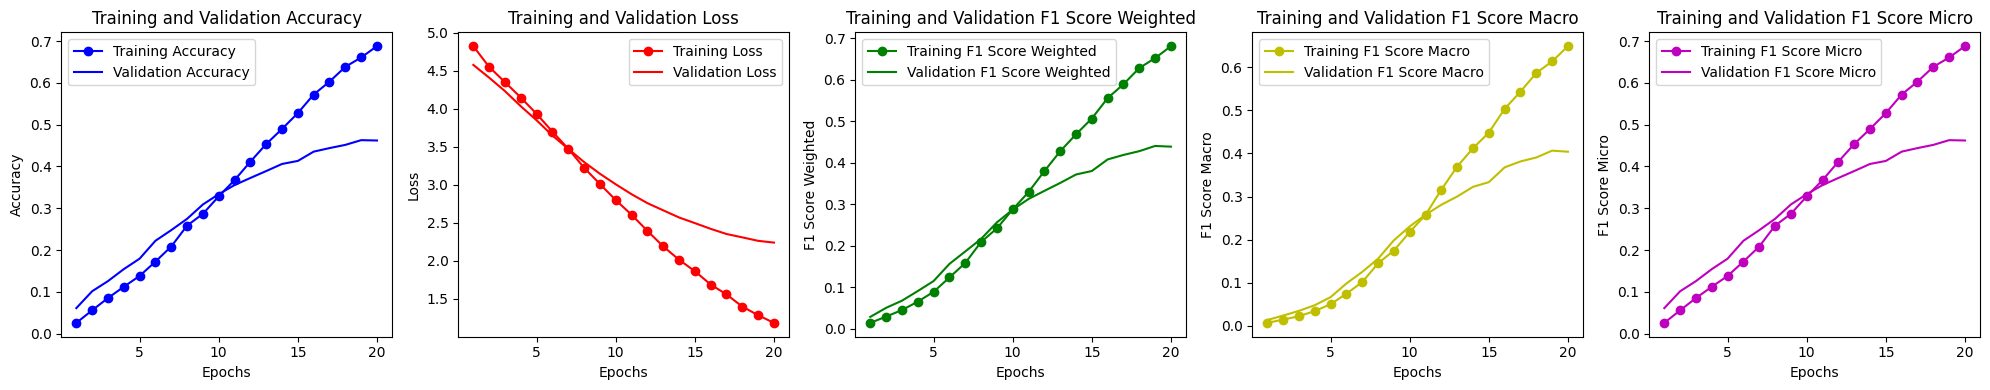

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score_weighted = history.history['f1_score_weighted']
val_f1_score_weighted = history.history['val_f1_score_weighted']
f1_score_macro = history.history['f1_score_macro']
val_f1_score_macro = history.history['val_f1_score_macro']
f1_score_micro = history.history['f1_score_micro']
val_f1_score_micro = history.history['val_f1_score_micro']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 5, 2)
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 5, 3)
plt.plot(epochs, f1_score_weighted, 'go-', label='Training F1 Score Weighted')
plt.plot(epochs, val_f1_score_weighted, 'g-', label='Validation F1 Score Weighted')
plt.title('Training and Validation F1 Score Weighted')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Weighted')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(epochs, f1_score_macro, 'yo-', label='Training F1 Score Macro')
plt.plot(epochs, val_f1_score_macro, 'y-', label='Validation F1 Score Macro')
plt.title('Training and Validation F1 Score Macro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Macro')
plt.legend()

plt.subplot(1, 5, 5)
plt.plot(epochs, f1_score_micro, 'mo-', label='Training F1 Score Micro')
plt.plot(epochs, val_f1_score_micro, 'm-', label='Validation F1 Score Micro')
plt.title('Training and Validation F1 Score Micro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Micro')
plt.legend()

plt.tight_layout()
plt.show()

# Multi Input - AdaGrad

In [33]:
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_input = Input(shape=(300, 300, 3), name='image_input')
features_input = Input(shape=(3,), name='features_input')

dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)

image_features = base_model(image_input)
image_flattened = Flatten()(image_features)
dense_output_1 = dense_layer_1(image_flattened)
dropout_output_1 = dropout_1(dense_output_1)
dense_output_2 = dense_layer_2(dropout_output_1)
dropout_output_2 = dropout_2(dense_output_2)

dropout_4 = layers.Dropout(0.5)
dropout_5 = layers.Dropout(0.5)
dropout_6 = layers.Dropout(0.5)

features_mlp = Dense(512, activation='relu')(features_input)
features_mlp = Dense(256, activation='relu')(features_mlp)
features_mlp = Dense(128, activation='relu')(features_mlp)

concatenated = Concatenate()([dropout_output_2, features_mlp])

x = Dense(256, activation='relu')(concatenated)
output = Dense(114, activation='softmax')(x)

model = Model(inputs=[image_input, features_input], outputs=output)

run the model

In [34]:
base_learning_rate = 0.00001

model.compile(optimizer=optimizers.Adagrad(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score_weighted"),
                       F1Score(average='micro', name = "f1_score_micro"), F1Score(average='macro', name = "f1_score_macro")])

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

history = model.fit({'image_input': X_train_img, 'features_input': X_train_features},
                    y_train_encoded_onehot,
                    epochs=20,
                    validation_data=({'image_input': X_val_img, 'features_input': X_val_features}, y_val_encoded_onehot),
                    callbacks=[es],
                    shuffle = True)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 319s 530ms/step - accuracy: 0.0110 - f1_score_macro: 0.0064 - f1_score_micro: 0.0110 - f1_score_weighted: 0.0072 - loss: 5.1716 - val_accuracy: 0.0093 - val_f1_score_macro: 0.0048 - val_f1_score_micro: 0.0093 - val_f1_score_weighted: 0.0043 - val_loss: 4.7913
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 111s 288ms/step - accuracy: 0.0086 - f1_score_macro: 0.0053 - f1_score_micro: 0.0086 - f1_score_weighted: 0.0065 - loss: 5.0759 - val_accuracy: 0.0089 - val_f1_score_macro: 0.0037 - val_f1_score_micro: 0.0089 - val_f1_score_weighted: 0.0057 - val_loss: 4.7665
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 112s 290ms/step - accuracy: 0.0099 - f1_score_macro: 0.0039 - f1_score_micro: 0.0099 - f1_score_weighted: 0.0064 - loss: 5.0337 - val_accuracy: 0.0121 - val_f1_score_macro: 0.0054 - val_f1_score_micro: 0.0121 - val_f1_score_weighted: 0.0096 - val_loss: 4.7504
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 113s 291ms/step - accuracy: 0.0100 - f1_score_macro: 0.0053 

predict on the model with test data

In [35]:
evaluation_result = model.evaluate({'image_input': X_test_img, 'features_input': X_test_features}, y_test_encoded_onehot)
print("Evaluation result:", evaluation_result)

y_pred = model.predict({'image_input': X_test_img, 'features_input': X_test_features})
y_pred_classes = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.0211 - f1_score_macro: 0.0061 - f1_score_micro: 0.0211 - f1_score_weighted: 0.0158 - loss: 4.6703
Evaluation result: [4.669953346252441, 0.02665051445364952, 0.020077502354979515, 0.02665046416223049, 0.008692051284015179]
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step


get the classification report

In [36]:
y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded_onehot, axis=1))
y_pred_classes_original = label_encoder.inverse_transform(y_pred_classes)

report = classification_report(y_test_original, y_pred_classes_original)

print(report)

                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.00      0.00      0.00         9
                                                 acne       0.00      0.00      0.00        19
                                        acne vulgaris       0.00      0.00      0.00        34
acquired autoimmune bullous diseaseherpes gestationis       0.00      0.00      0.00         6
                         acrodermatitis enteropathica       0.00      0.00      0.00         9
                                    actinic keratosis       1.00      0.06      0.11        18
                          allergic contact dermatitis       0.00      0.00      0.00        43
                                        aplasia cutis       0.00      0.00      0.00         7
                                 basal cell carcinoma       0.15      0.26      0.19        47
                     basal cell carcinoma morphei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='weighted')
print("Weighted F1 Score : ", f1)

Weighted F1 Score :  0.020077512446394885


In [38]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.026650514839491216


In [39]:
f1 = f1_score(y_test_original, y_pred_classes_original, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.008692055175650141


In [40]:
final_val_loss = history.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 4.659303665161133


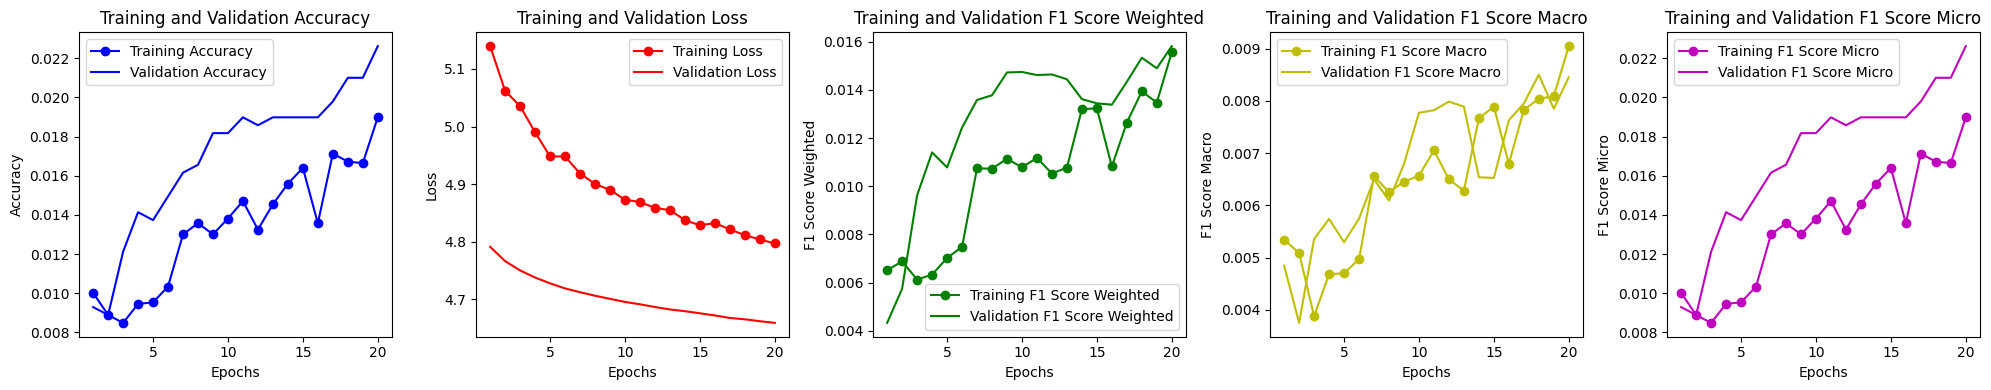

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score_weighted = history.history['f1_score_weighted']
val_f1_score_weighted = history.history['val_f1_score_weighted']
f1_score_macro = history.history['f1_score_macro']
val_f1_score_macro = history.history['val_f1_score_macro']
f1_score_micro = history.history['f1_score_micro']
val_f1_score_micro = history.history['val_f1_score_micro']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 5, 2)
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 5, 3)
plt.plot(epochs, f1_score_weighted, 'go-', label='Training F1 Score Weighted')
plt.plot(epochs, val_f1_score_weighted, 'g-', label='Validation F1 Score Weighted')
plt.title('Training and Validation F1 Score Weighted')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Weighted')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(epochs, f1_score_macro, 'yo-', label='Training F1 Score Macro')
plt.plot(epochs, val_f1_score_macro, 'y-', label='Validation F1 Score Macro')
plt.title('Training and Validation F1 Score Macro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Macro')
plt.legend()

plt.subplot(1, 5, 5)
plt.plot(epochs, f1_score_micro, 'mo-', label='Training F1 Score Micro')
plt.plot(epochs, val_f1_score_micro, 'm-', label='Validation F1 Score Micro')
plt.title('Training and Validation F1 Score Micro')
plt.xlabel('Epochs')
plt.ylabel('F1 Score Micro')
plt.legend()

plt.tight_layout()
plt.show()